In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Convert image to Grayscale! - img = cv2.cvtColor(img, cv2.COLOR_BAYER_BG2GRAY) - plt.imshow(bin_img,cmap='Greys_r')

# For thresholding the source image should be a grayscale image
# Why 256 pixels - grayscale, RGB
# Dilating (img) is same as eroding (255-img)

# 255 - White - high value - high intensity!
# 0 - Black - low value - low intensity!
# grayscale value at (i, j) = 0.2989 * R(i, j) + 0.5870 * G(i, j) + 0.1140 * B(i, j)

In [3]:
from scipy import ndimage

a = np.array([[50,50,100,100],
              [50,50,100,100],
              [50,50,100,100],
              [50,50,100,100]])

def sobel_filters(img):
    
    Kx = np.array([[-1, 0, 1],
                   [-2, 0, 2],
                   [-1, 0, 1]], np.float32)
    
    Ky = np.array([[1, 2, 1],
                   [0, 0, 0],
                   [-1,-2,-1]], np.float32)
    
    Ix = ndimage.filters.convolve(img, Kx)
    Iy = ndimage.filters.convolve(img, Ky)
    
    G = np.hypot(Ix, Iy)
    G = G / G.max() * 255
    theta = np.arctan2(Iy, Ix)
    
    return (Ix)

# Steps involved in pre-processing for OCR
        * Edge detection using Canny
            - Noise Reduction (Bluring)
            - Finding Intensity Gradient of the Image using Sobel or Laplacian (White pixel means 'high' gradient value)
            - Non-maximum Suppression 
            - Hysteresis Thresholding
            
        * Thicken the edges using Morphological transformations using a kernel (Rectangular, Elliptical, Cross-shaped)
            - Erosion
            - Dilation
            - Opening
            - Closing etc..
            
        * Finding contours
        * Flattenig or changing the perspective of the document
        * Smoothen the warped image using a Gaussian Filter to remove noise
        * Binarization and Thresholding
        

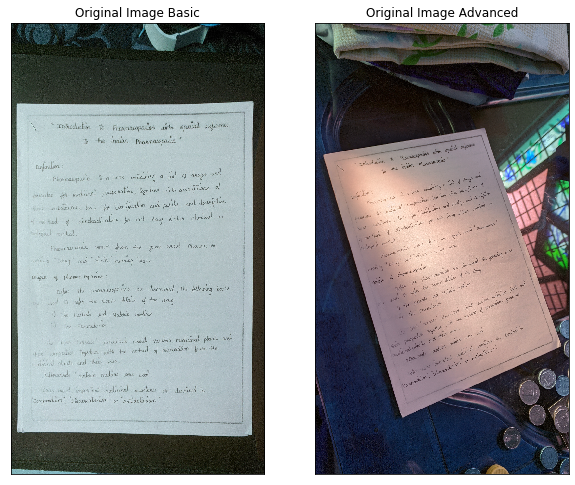

In [5]:
# Opening the original image
img_original_basic = cv2.imread('document_basic.png',1)
img_original_adv = cv2.imread('document_adv.png',1)

# Opening the same image in Grayscale form
img_basic = cv2.imread('document_basic.png',0)
img_adv = cv2.imread('document_adv.png',0)

plt.figure(figsize=(10,10))

plt.subplot(121)
plt.imshow(img_original_basic)
plt.title('Original Image Basic')
plt.xticks([])
plt.yticks([])

plt.subplot(122)
plt.imshow(img_original_adv)
plt.title('Original Image Advanced')
plt.xticks([])
plt.yticks([])


plt.show()

# Edge Detection using Canny

Text(0.5, 1.0, 'Edge Image Basic')

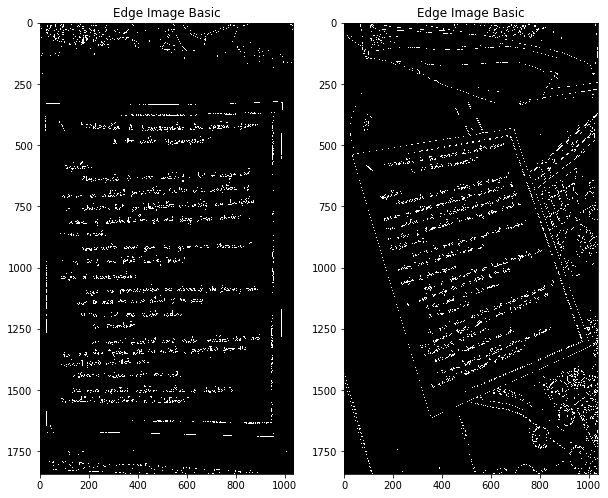

In [6]:
edge_basic = cv2.Canny(img_basic,100,200)
edge_adv = cv2.Canny(img_adv,100,200)

plt.figure(figsize=(10,10))

plt.subplot(121)
plt.imshow(edge_basic,cmap='gray')
plt.title('Edge Image Basic')

plt.subplot(122)
plt.imshow(edge_adv,cmap='gray')
plt.title('Edge Image Basic')

# Morphological Transformations

Text(0.5, 1.0, 'Dilated Image Advanced')

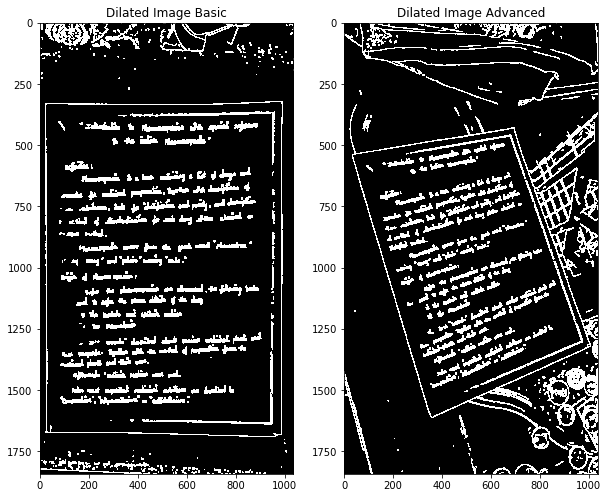

In [14]:
# When to use which kernel... (Rectangular, Elliptical, Cross-shaped)
kernel = np.ones((5,5),np.uint8)
dilation_basic = cv2.dilate(edge_basic,kernel,iterations = 1)
dilation_adv = cv2.dilate(edge_adv,kernel,iterations = 1)

plt.figure(figsize=(10,10))

plt.subplot(121)
plt.imshow(dilation_basic,cmap = 'gray')
plt.title('Dilated Image Basic')

plt.subplot(122)
plt.imshow(dilation_adv,cmap='gray')
plt.title('Dilated Image Advanced')

# Finding Contours
* And approximating the contour to a 'rectangle with the largest area'

([], <a list of 0 Text yticklabel objects>)

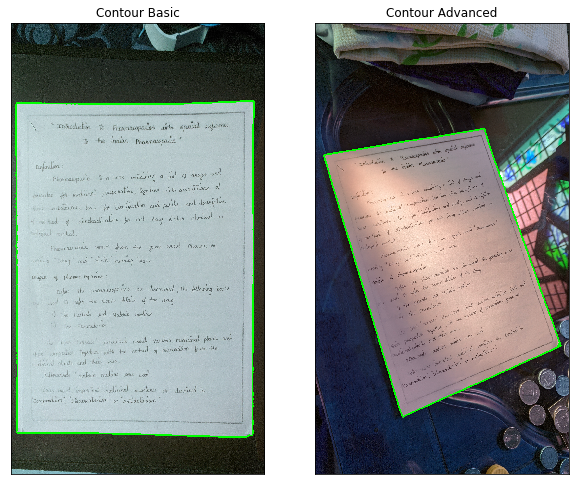

In [15]:
# Retrieve the contours as a list, with simple apprximation model (returms the corner points alone..)
contours_basic,hierarchy_basic=cv2.findContours(dilation_basic,cv2.RETR_LIST,cv2.CHAIN_APPROX_SIMPLE)  
contours_basic=sorted(contours_basic,key=cv2.contourArea,reverse=True)

corner_pts_basic = 0
pos_basic = 0

for i in range(len(contours_basic)):
    epsilon = 0.01*cv2.arcLength(contours_basic[i], True)
    approx = cv2.approxPolyDP(contours_basic[i], epsilon, True)
    
    if len(approx) == 4:
        corner_pts_basic = approx
        pos_basic = i
        break
        
c_img_basic = cv2.drawContours(cv2.imread('document_basic.png',1), contours_basic, pos_basic, (0,255,0), 5)


contours_adv,hierarchy_adv=cv2.findContours(dilation_adv,cv2.RETR_LIST,cv2.CHAIN_APPROX_SIMPLE)  
contours_adv=sorted(contours_adv,key=cv2.contourArea,reverse=True)

corner_pts_adv = 0
pos_adv = 0

for i in range(len(contours_adv)):
    epsilon = 0.01*cv2.arcLength(contours_adv[i], True)
    approx = cv2.approxPolyDP(contours_adv[i], epsilon, True)
    
    if len(approx) == 4:
        corner_pts_adv = approx
        pos_adv = i
        break 

c_img_adv = cv2.drawContours(cv2.imread('document_adv.png',1), contours_adv, pos_adv, (0,255,0), 5)

# Display image
plt.figure(figsize=(10,10))

plt.subplot(121)
plt.imshow(c_img_basic,cmap = 'gray')
plt.title('Contour Basic')
plt.xticks([])
plt.yticks([])

plt.subplot(122)
plt.imshow(c_img_adv,cmap='gray')
plt.title('Contour Advanced')
plt.xticks([])
plt.yticks([])

# Flattening The Document

In [19]:
def order_points(pts):

    rect = np.zeros((4, 2), dtype = "float32")
    
    s = pts.sum(axis = 1)
    rect[0] = pts[np.argmin(s)]
    rect[2] = pts[np.argmax(s)]

    diff = np.diff(pts, axis = 1)
    rect[1] = pts[np.argmin(diff)]
    rect[3] = pts[np.argmax(diff)]

    return rect

def four_point_transform(image, pts):

    rect = order_points(pts)
    (tl, tr, br, bl) = rect

    widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
    widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
    maxWidth = max(int(widthA), int(widthB))

    heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
    heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
    maxHeight = max(int(heightA), int(heightB))

    dst = np.array([
        [0, 0],
        [maxWidth - 1, 0],
        [maxWidth - 1, maxHeight - 1],
        [0, maxHeight - 1]], dtype = "float32")

    M = cv2.getPerspectiveTransform(rect, dst)
    warped = cv2.warpPerspective(image, M, (maxWidth, maxHeight))

    return warped

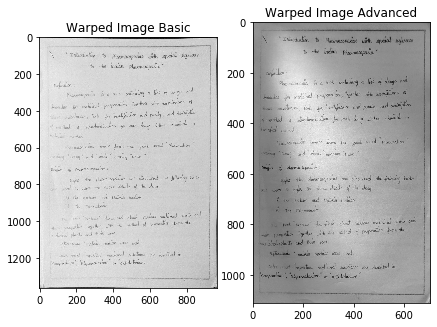

In [25]:
warped_img_basic = four_point_transform(img_basic, corner_pts_basic.reshape(4,2))
warped_img_adv = four_point_transform(img_adv, corner_pts_adv.reshape(4,2))

plt.figure(figsize=(7,7))

plt.subplot(121)
plt.title('Warped Image Basic')
plt.imshow(warped_img_basic,'gray')

plt.subplot(122)
plt.title('Warped Image Advanced')
plt.imshow(warped_img_adv,'gray')

# Thresholding

- The 4th parameter ('C' value) in adaptiveThreshold is very important
- For example take zone (a whitespace where in the document) where all the pixels are identical
- if we are appling adaptiveThreshold using 'ADAPTIVE_THRESH_MEAN_C' we will get a mean of 255 (since the zone consist of identical whitespaces) 
- We subtract the the 'C' value from the mean (255)

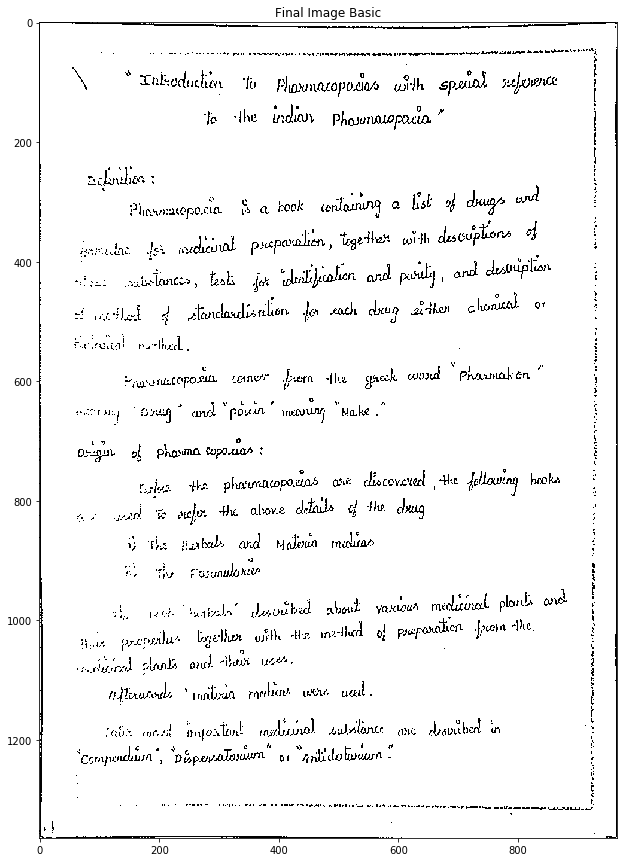

In [37]:
warped_blur_basic = cv2.GaussianBlur(warped_img_basic,(5,5),0)
bin_img_basic = cv2.adaptiveThreshold(warped_blur_basic,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY,3,2)

plt.figure(figsize=(15,15))
plt.title('Final Image Basic')
plt.imshow(bin_img_basic,'gray')

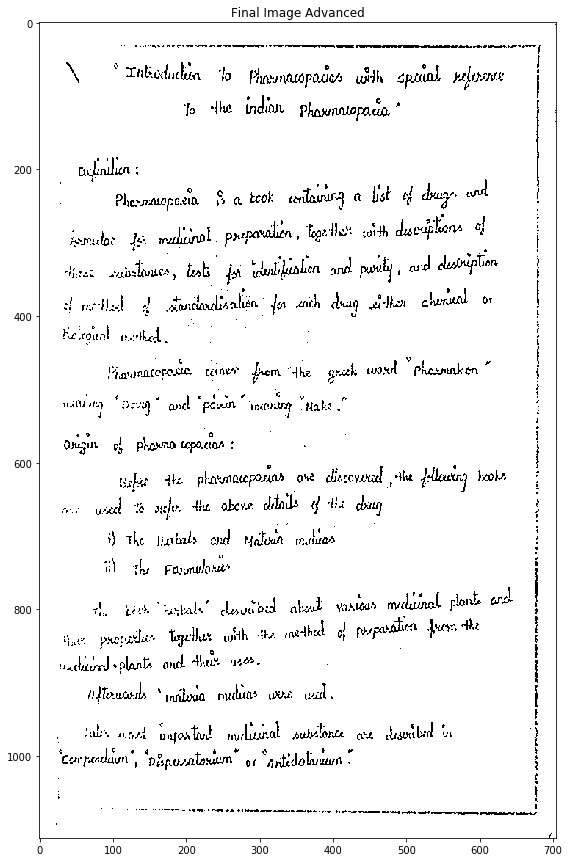

In [32]:
warped_blur_adv = cv2.GaussianBlur(warped_img_adv,(5,5),0)
bin_img_adv = cv2.adaptiveThreshold(warped_blur_adv,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY,3,2)

plt.figure(figsize=(15,15))
plt.title('Final Image Advanced')
plt.imshow(bin_img_adv,'gray')